In [ ]:
import pandas as pd
import os
import sys
from datetime import datetime
from dateutil import tz
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
import AOD_data
import importlib
import numpy as np
from sklearn import linear_model
importlib.reload(AOD_data)

<module 'AOD_data' from '/mnt/HDD2/Cgeo/git/contaminantes_satelites/src/AOD_data.py'>

In [ ]:
AOD_dat = AOD_data.load_AOD_data('../data_s/red_estaciones_todos_2018.csv')


Converting to local time:  America/Mexico_City


* (Antes) Los datos de PM25 que nos mandaro no creo que esten bien o hay varias dudas al respecto, en particular con los valores donde aparecen con valor $1$ creo que para este ejercicio es mejor usar los datos de RAMA pues los datos tienen mas sentido.
* (Actualización) Efectivamente los datos con valor $1$ no son correctos, entonces se cambiaron dichos valores y se pusieron como NA. Los cambios se realizaron en la base de datos del INSP por lo que para este ejercicio no es necesario que se cambien dentro de este notebook. Pero si se tiene que modificar para usar la base de datos correcta. 

In [ ]:
PM25_dat = pd.read_csv('../data_s/PM25_val_full.csv')


/tmp/ipykernel_10232/1073438094.py:1: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  PM25_dat = pd.read_csv('../data_s/PM25_val_full.csv')


In [ ]:
PM25_dat.head()

,Unnamed: 0,ZM,CVE_EST,FECHA_HR,PARAMETRO,VALOR,UNIDAD
0,1,AMM,CE_AMM,2004-01-01 00:00:00,pm2.5,NaN,µg/m<sup>3</sup>
1,2,AMM,CE_AMM,2004-01-01 01:00:00,pm2.5,118.0,µg/m<sup>3</sup>
2,3,AMM,CE_AMM,2004-01-01 02:00:00,pm2.5,135.0,µg/m<sup>3</sup>
3,4,AMM,CE_AMM,2004-01-01 03:00:00,pm2.5,72.0,µg/m<sup>3</sup>
4,5,AMM,CE_AMM,2004-01-01 04:00:00,pm2.5,60.0,µg/m<sup>3</sup>


In [ ]:
initial_interval= '2018-01-01'
end_interval = '2019-01-01'
zona_metropoli = 'ZMVM'
PM25_dat= PM25_dat[PM25_dat['VALOR'].isna() ==False] #drop NaN values 
PM25_dat.FECHA_HR= pd.to_datetime(PM25_dat.FECHA_HR) #to datetime
PM25_dat_interval=  PM25_dat[(PM25_dat.FECHA_HR >= pd.to_datetime(initial_interval)) &
                             (PM25_dat.FECHA_HR < pd.to_datetime(end_interval))
                            ] ### get interval 
PM25_dat_interval= PM25_dat_interval[PM25_dat_interval['CVE_EST'].apply(lambda l: zona_metropoli in l)]
PM25_dat_interval['Estacion']   = PM25_dat_interval['CVE_EST'].apply(lambda l: l.split('_')[0])
PM25_dat_interval['FECHA_date'] = PM25_dat_interval['FECHA_HR'].apply(lambda l: l.date())
PM25_dat_interval['FECHA_hora'] = PM25_dat_interval['FECHA_HR'].apply(lambda l: l.hour)

In [ ]:
PM25_dat_interval.head()

,Unnamed: 0,ZM,CVE_EST,FECHA_HR,PARAMETRO,VALOR,UNIDAD,Estacion,FECHA_date,FECHA_hora
3543992,3543993,ZMVM,CAM_ZMVM,2018-01-17 03:00:00,pm2.5,17.0,µg/m<sup>3</sup>,CAM,2018-01-17,3
3543993,3543994,ZMVM,CAM_ZMVM,2018-01-17 04:00:00,pm2.5,23.0,µg/m<sup>3</sup>,CAM,2018-01-17,4
3543994,3543995,ZMVM,CAM_ZMVM,2018-01-17 05:00:00,pm2.5,12.0,µg/m<sup>3</sup>,CAM,2018-01-17,5
3543995,3543996,ZMVM,CAM_ZMVM,2018-01-17 06:00:00,pm2.5,18.0,µg/m<sup>3</sup>,CAM,2018-01-17,6
3543996,3543997,ZMVM,CAM_ZMVM,2018-01-17 07:00:00,pm2.5,27.0,µg/m<sup>3</sup>,CAM,2018-01-17,7


In [ ]:
AOD_dat.head()

,Optical_Depth_047,AOD_Uncertainty,hour_day,timestamp,Estacion,TIME_STAMP,Local_time,Local_time_hour,Local_time_date
84,939.0,197.0,19,2018-01-01T19:40:00,DIC,2018-01-01 19:40:00,2018-01-01 13:40:00-06:00,13,2018-01-01
86,1171.0,239.0,19,2018-01-01T19:40:00,CCA,2018-01-01 19:40:00,2018-01-01 13:40:00-06:00,13,2018-01-01
87,920.0,238.0,19,2018-01-01T19:40:00,UAX,2018-01-01 19:40:00,2018-01-01 13:40:00-06:00,13,2018-01-01
89,680.0,454.0,19,2018-01-01T19:40:00,UIZ,2018-01-01 19:40:00,2018-01-01 13:40:00-06:00,13,2018-01-01
90,970.0,194.0,19,2018-01-01T19:40:00,MPA,2018-01-01 19:40:00,2018-01-01 13:40:00-06:00,13,2018-01-01


In [ ]:

# AOD_PM25_all_2018 = AOD_data.merge_AOD_PM25(AOD_dat,
                                            
#                                             PM25_dat_interval)
AOD_PM25_esta =  AOD_dat.merge(PM25_dat_interval,
                                how= 'left',
                                right_on = ['Estacion', 'FECHA_date', 'FECHA_hora' ],
                                left_on=['Estacion','Local_time_date', 'Local_time_hour'  ]
                                 )
AOD_PM25_esta=  AOD_PM25_esta[AOD_PM25_esta['VALOR'].isna()==False]
AOD_PM25_esta.head()

,Optical_Depth_047,AOD_Uncertainty,hour_day,timestamp,Estacion,TIME_STAMP,Local_time,Local_time_hour,Local_time_date,Unnamed: 0,ZM,CVE_EST,FECHA_HR,PARAMETRO,VALOR,UNIDAD,FECHA_date,FECHA_hora
14,710.0,311.0,19,2018-01-01T19:40:00,MER,2018-01-01 19:40:00,2018-01-01 13:40:00-06:00,13,2018-01-01,5033110.0,ZMVM,MER_ZMVM,2018-01-01 13:00:00,pm2.5,64.0,µg/m<sup>3</sup>,2018-01-01,13.0
21,704.0,412.0,19,2018-01-01T19:40:00,NEZ,2018-01-01 19:40:00,2018-01-01 13:40:00-06:00,13,2018-01-01,5402575.0,ZMVM,NEZ_ZMVM,2018-01-01 13:00:00,pm2.5,31.0,µg/m<sup>3</sup>,2018-01-01,13.0
22,653.0,639.0,19,2018-01-01T19:40:00,SAG,2018-01-01 19:40:00,2018-01-01 13:40:00-06:00,13,2018-01-01,5914128.0,ZMVM,SAG_ZMVM,2018-01-01 13:00:00,pm2.5,35.0,µg/m<sup>3</sup>,2018-01-01,13.0
24,806.0,476.0,19,2018-01-01T19:40:00,TLA,2018-01-01 19:40:00,2018-01-01 13:40:00-06:00,13,2018-01-01,6599655.0,ZMVM,TLA_ZMVM,2018-01-01 13:00:00,pm2.5,44.0,µg/m<sup>3</sup>,2018-01-01,13.0
38,419.0,131.0,18,2018-01-03T18:00:00,NEZ,2018-01-03 18:00:00,2018-01-03 12:00:00-06:00,12,2018-01-03,5402622.0,ZMVM,NEZ_ZMVM,2018-01-03 12:00:00,pm2.5,29.0,µg/m<sup>3</sup>,2018-01-03,12.0


Este dataframe contiene ya los datos de AOD junto con los datos disponibles de PM $2.5$ de las estaciones de la ZMVM. 




## Climate Data
A continuacion tomamos los datos obtenido de los reaaálisis de los datos climaticos a partir de satelite para las estaciones en las fechas antes mencionadas. 


In [ ]:
temp_2018_01_02 = pd.read_csv('../data_s/red_est_ERA5_LAND_HOURLY_2018_01_to_02.csv')
temp_2018_03_04 = pd.read_csv('../data_s/red_est_ERA5_LAND_HOURLY_2018_03_to_04.csv')
temp_2018_05_06 = pd.read_csv('../data_s/red_est_ERA5_LAND_HOURLY_2018_05_to_06.csv')
temp_2018_07_08 = pd.read_csv('../data_s/red_est_ERA5_LAND_HOURLY_2018_07_to_08.csv')
temp_2018_09_10 = pd.read_csv('../data_s/red_est_ERA5_LAND_HOURLY_2018_09_to_10.csv')
temp_2018_11_12 = pd.read_csv('../data_s/red_est_ERA5_LAND_HOURLY_2018_11_to_12.csv')
temp_2018= pd.concat([temp_2018_01_02,
                      temp_2018_03_04,
                      temp_2018_05_06,
                      temp_2018_07_08,
                      temp_2018_09_10,
                      temp_2018_11_12,
                     ])
temp_2018.head()

,id,temperature_2m,total_evaporation,u_component_of_wind_10m,v_component_of_wind_10m,total_precipitation,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation,total_precipitation_hourly,timestamp
0,AJU,285.002533,-0.000869,0.781372,0.862854,0.000005,4.858032,2.128418,0.0,2018-01-01T01:00:00
1,AJM,288.656830,-0.000988,0.602661,0.233948,0.000005,0.843750,1.616577,0.0,2018-01-01T01:00:00
2,DIC,288.656830,-0.000988,0.602661,0.233948,0.000005,0.843750,1.616577,0.0,2018-01-01T01:00:00
3,EAJ,288.656830,-0.000988,0.602661,0.233948,0.000005,0.843750,1.616577,0.0,2018-01-01T01:00:00
4,CCA,288.656830,-0.000988,0.602661,0.233948,0.000005,0.843750,1.616577,0.0,2018-01-01T01:00:00


In [ ]:
temp_2018['Estacion']= temp_2018['id']
temp_2018['TIME_STAMP'] = pd.to_datetime(temp_2018['timestamp']) ### 
### Change time zone 
local_time = 'America/Mexico_City'
print('Converting to local time: ', local_time)
temp_2018['Local_time']= temp_2018['TIME_STAMP'].dt.tz_localize('UTC').dt.tz_convert(local_time)
#tz_localize('utc').tz_convert('America/Mexico_City')
temp_2018['Local_time'+'_hour'] = temp_2018['Local_time'].apply(lambda l: l.hour)
temp_2018['Local_time'+'_date'] = temp_2018['Local_time'].apply(lambda l: l.date)
temp_2018.head()

Converting to local time:  America/Mexico_City


,id,temperature_2m,total_evaporation,u_component_of_wind_10m,v_component_of_wind_10m,total_precipitation,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation,total_precipitation_hourly,timestamp,Estacion,TIME_STAMP,Local_time,Local_time_hour,Local_time_date
0,AJU,285.002533,-0.000869,0.781372,0.862854,0.000005,4.858032,2.128418,0.0,2018-01-01T01:00:00,AJU,2018-01-01 01:00:00,2017-12-31 19:00:00-06:00,19,2017-12-31
1,AJM,288.656830,-0.000988,0.602661,0.233948,0.000005,0.843750,1.616577,0.0,2018-01-01T01:00:00,AJM,2018-01-01 01:00:00,2017-12-31 19:00:00-06:00,19,2017-12-31
2,DIC,288.656830,-0.000988,0.602661,0.233948,0.000005,0.843750,1.616577,0.0,2018-01-01T01:00:00,DIC,2018-01-01 01:00:00,2017-12-31 19:00:00-06:00,19,2017-12-31
3,EAJ,288.656830,-0.000988,0.602661,0.233948,0.000005,0.843750,1.616577,0.0,2018-01-01T01:00:00,EAJ,2018-01-01 01:00:00,2017-12-31 19:00:00-06:00,19,2017-12-31
4,CCA,288.656830,-0.000988,0.602661,0.233948,0.000005,0.843750,1.616577,0.0,2018-01-01T01:00:00,CCA,2018-01-01 01:00:00,2017-12-31 19:00:00-06:00,19,2017-12-31


Podemos obtener el dataframe de los valores en cada momento, esto sólo se hace para tener esa información, pero no se usa de esta forma en los datos para los modelos. 

In [ ]:
temp_PM25_esta =  AOD_PM25_esta.merge(temp_2018,
                                  how= 'left',
                                  right_on = ['Estacion','Local_time_hour' , 'Local_time_date' ],
                                  left_on=['Estacion','Local_time_hour' ,'Local_time_date' ]
                                 )
temp_PM25_esta=  temp_PM25_esta[temp_PM25_esta['VALOR'].isna()==False]

In [ ]:
temp_PM25_esta.head(50)

,Optical_Depth_047,AOD_Uncertainty,hour_day,timestamp_x,Estacion,TIME_STAMP_x,Local_time_x,Local_time_hour,Local_time_date,Unnamed: 0,...,total_evaporation,u_component_of_wind_10m,v_component_of_wind_10m,total_precipitation,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation,total_precipitation_hourly,timestamp_y,TIME_STAMP_y,Local_time_y
0,710.0,311.0,19,2018-01-01T19:40:00,MER,2018-01-01 19:40:00,2018-01-01 13:40:00-06:00,13,2018-01-01,5033110.0,...,-0.000171,-0.496094,-1.957537,3.059596e-04,0.0000,0.584717,0.000041,2018-01-01T19:00:00,2018-01-01 19:00:00,2018-01-01 13:00:00-06:00
1,704.0,412.0,19,2018-01-01T19:40:00,NEZ,2018-01-01 19:40:00,2018-01-01 13:40:00-06:00,13,2018-01-01,5402575.0,...,-0.000331,-0.180664,-2.061052,2.415270e-04,0.0000,1.165161,0.000042,2018-01-01T19:00:00,2018-01-01 19:00:00,2018-01-01 13:00:00-06:00
2,653.0,639.0,19,2018-01-01T19:40:00,SAG,2018-01-01 19:40:00,2018-01-01 13:40:00-06:00,13,2018-01-01,5914128.0,...,-0.000332,-0.355469,-2.136736,2.528369e-04,0.0000,1.138184,0.000031,2018-01-01T19:00:00,2018-01-01 19:00:00,2018-01-01 13:00:00-06:00
3,806.0,476.0,19,2018-01-01T19:40:00,TLA,2018-01-01 19:40:00,2018-01-01 13:40:00-06:00,13,2018-01-01,6599655.0,...,-0.000206,-0.967773,-1.855974,2.272815e-04,4.4375,0.652344,0.000024,2018-01-01T19:00:00,2018-01-01 19:00:00,2018-01-01 13:00:00-06:00
4,419.0,131.0,18,2018-01-03T18:00:00,NEZ,2018-01-03 18:00:00,2018-01-03 12:00:00-06:00,12,2018-01-03,5402622.0,...,-0.000174,0.586761,-1.299316,2.020597e-06,0.0000,1.156128,0.000000,2018-01-03T18:00:00,2018-01-03 18:00:00,2018-01-03 12:00:00-06:00
5,442.0,180.0,18,2018-01-03T18:00:00,SAG,2018-01-03 18:00:00,2018-01-03 12:00:00-06:00,12,2018-01-03,5914175.0,...,-0.000183,0.493988,-1.350098,1.439452e-06,0.0000,1.130493,0.000000,2018-01-03T18:00:00,2018-01-03 18:00:00,2018-01-03 12:00:00-06:00
6,647.0,222.0,19,2018-01-03T19:25:00,NEZ,2018-01-03 19:25:00,2018-01-03 13:25:00-06:00,13,2018-01-03,5402623.0,...,-0.000358,0.820496,-1.947619,2.020597e-06,0.0000,1.156128,0.000000,2018-01-03T19:00:00,2018-01-03 19:00:00,2018-01-03 13:00:00-06:00
7,674.0,1181.0,20,2018-01-04T20:10:00,NEZ,2018-01-04 20:10:00,2018-01-04 14:10:00-06:00,14,2018-01-04,5402648.0,...,-0.000606,1.160187,-1.360596,1.558661e-06,0.0000,1.151733,0.000000,2018-01-04T20:00:00,2018-01-04 20:00:00,2018-01-04 14:00:00-06:00
8,538.0,2060.0,20,2018-01-04T20:10:00,SAG,2018-01-04 20:10:00,2018-01-04 14:10:00-06:00,14,2018-01-04,5914201.0,...,-0.000540,1.050812,-1.779541,2.139807e-06,0.0000,1.126709,0.000000,2018-01-04T20:00:00,2018-01-04 20:00:00,2018-01-04 14:00:00-06:00
9,566.0,777.0,20,2018-01-06T20:00:00,MER,2018-01-06 20:00:00,2018-01-06 14:00:00-06:00,14,2018-01-06,5033231.0,...,-0.000403,0.056320,-2.386703,3.125283e-06,0.0000,0.580566,0.000000,2018-01-06T20:00:00,2018-01-06 20:00:00,2018-01-06 14:00:00-06:00


## Data to use. 

Podemos utilizar los datos y hacer un merge (como se hizo arriba) para obtener los datos de *AOD* y clima junto con los datos de las estaciones. Pero no estoy seguro que nos interese hacer tal cosa, si no obtener los promedios y utilizar los valores de dichos promedios para usarlos dentro de un modelo lineal para la obtencion de PM $2.5$.

Como la restricción la tenemos en los datos de *AOD*, pues el satelite que toma las mediciones pasa sólo una vez al día, usaremos estos para determinar como tomar los datos 

<AxesSubplot: >

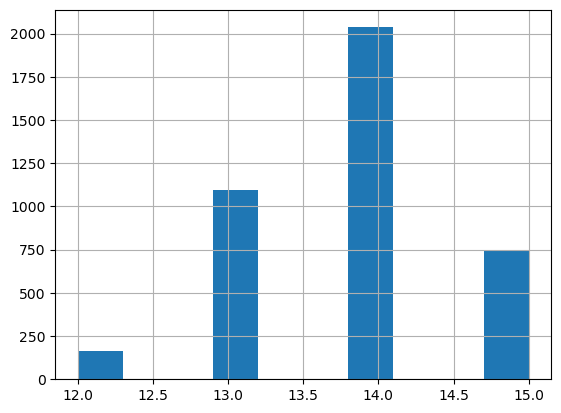

In [ ]:
AOD_dat['Local_time_hour'].hist()

Tomemos 

In [ ]:

AOD_dat['Mes'] = AOD_dat['Local_time'].apply(lambda l: l.month)
AOD_dat.head()

,Optical_Depth_047,AOD_Uncertainty,hour_day,timestamp,Estacion,TIME_STAMP,Local_time,Local_time_hour,Local_time_date,Mes
84,939.0,197.0,19,2018-01-01T19:40:00,DIC,2018-01-01 19:40:00,2018-01-01 13:40:00-06:00,13,2018-01-01,1
86,1171.0,239.0,19,2018-01-01T19:40:00,CCA,2018-01-01 19:40:00,2018-01-01 13:40:00-06:00,13,2018-01-01,1
87,920.0,238.0,19,2018-01-01T19:40:00,UAX,2018-01-01 19:40:00,2018-01-01 13:40:00-06:00,13,2018-01-01,1
89,680.0,454.0,19,2018-01-01T19:40:00,UIZ,2018-01-01 19:40:00,2018-01-01 13:40:00-06:00,13,2018-01-01,1
90,970.0,194.0,19,2018-01-01T19:40:00,MPA,2018-01-01 19:40:00,2018-01-01 13:40:00-06:00,13,2018-01-01,1


Vamos a obtener los datos promedios de *PM* $2.5$ para estas horas y para un mes en particular


In [ ]:
PM25_dat_interval['Mes']=PM25_dat_interval['FECHA_date'].apply(lambda l: l.month)

In [ ]:
horas_get= AOD_dat['Local_time_hour'].unique()


In [ ]:
horas_get

array([13, 12, 14, 15])

In [ ]:
PM25_dat_interval.drop(columns=['Unnamed: 0'], inplace =True, axis=1)
PM25_dat_interval.head()

,ZM,CVE_EST,FECHA_HR,PARAMETRO,VALOR,UNIDAD,Estacion,FECHA_date,FECHA_hora,Mes
3543992,ZMVM,CAM_ZMVM,2018-01-17 03:00:00,pm2.5,17.0,µg/m<sup>3</sup>,CAM,2018-01-17,3,1
3543993,ZMVM,CAM_ZMVM,2018-01-17 04:00:00,pm2.5,23.0,µg/m<sup>3</sup>,CAM,2018-01-17,4,1
3543994,ZMVM,CAM_ZMVM,2018-01-17 05:00:00,pm2.5,12.0,µg/m<sup>3</sup>,CAM,2018-01-17,5,1
3543995,ZMVM,CAM_ZMVM,2018-01-17 06:00:00,pm2.5,18.0,µg/m<sup>3</sup>,CAM,2018-01-17,6,1
3543996,ZMVM,CAM_ZMVM,2018-01-17 07:00:00,pm2.5,27.0,µg/m<sup>3</sup>,CAM,2018-01-17,7,1


In [ ]:
### Tomemos los datos de las estaciones que se encuentran en las horas de AOD 
PM25_dat_h = PM25_dat_interval[PM25_dat_interval['FECHA_hora'].apply(lambda l: l in horas_get)]
PM25_dat_h.head()

,ZM,CVE_EST,FECHA_HR,PARAMETRO,VALOR,UNIDAD,Estacion,FECHA_date,FECHA_hora,Mes
3544001,ZMVM,CAM_ZMVM,2018-01-17 12:00:00,pm2.5,44.0,µg/m<sup>3</sup>,CAM,2018-01-17,12,1
3544002,ZMVM,CAM_ZMVM,2018-01-17 13:00:00,pm2.5,17.0,µg/m<sup>3</sup>,CAM,2018-01-17,13,1
3544003,ZMVM,CAM_ZMVM,2018-01-17 14:00:00,pm2.5,22.0,µg/m<sup>3</sup>,CAM,2018-01-17,14,1
3544004,ZMVM,CAM_ZMVM,2018-01-17 15:00:00,pm2.5,44.0,µg/m<sup>3</sup>,CAM,2018-01-17,15,1
3544025,ZMVM,CAM_ZMVM,2018-01-18 12:00:00,pm2.5,53.0,µg/m<sup>3</sup>,CAM,2018-01-18,12,1


Por cada mes y por cada hora en las estaciones se toma el promedio del el valor PM 2.5

In [ ]:

PM25_month_hour=  PM25_dat_h.groupby( ['Mes','FECHA_hora', 'Estacion']).mean()
PM25_month_hour.head()

VALOR
Mes FECHA_hora Estacion           
1   12         CAM       38.272727
               MER       41.142857
               NEZ       39.290323
               SAG       33.727273
               TLA       40.366667

In [ ]:
###Para dejarlo como un solo datafreme y no un groupby
PM25_month_hour= PM25_month_hour.reset_index()
PM25_month_hour.head()

,Mes,FECHA_hora,Estacion,VALOR
0,1,12,CAM,38.272727
1,1,12,MER,41.142857
2,1,12,NEZ,39.290323
3,1,12,SAG,33.727273
4,1,12,TLA,40.366667


Hacemos lo mismo para los datos de AOD

In [ ]:
AOD_dat_month_hour=  AOD_dat.groupby( ['Mes','Local_time_hour', 'Estacion']).mean()
AOD_dat_month_hour.head()

Optical_Depth_047  AOD_Uncertainty  hour_day
Mes Local_time_hour Estacion                                              
1   12              CHO                   439.0            138.0      18.0
                    COR                   344.0             79.0      18.0
                    FAR                   420.0            126.0      18.0
                    IZT                   493.0            106.0      18.0
                    LLA                   383.0            159.0      18.0

In [ ]:
AOD_dat_month_hour = AOD_dat_month_hour.reset_index()
AOD_dat_month_hour.head()

,Mes,Local_time_hour,Estacion,Optical_Depth_047,AOD_Uncertainty,hour_day
0,1,12,CHO,439.0,138.0,18.0
1,1,12,COR,344.0,79.0,18.0
2,1,12,FAR,420.0,126.0,18.0
3,1,12,IZT,493.0,106.0,18.0
4,1,12,LLA,383.0,159.0,18.0


Y con los datos climáticos

In [ ]:
temp_2018.head()

,id,temperature_2m,total_evaporation,u_component_of_wind_10m,v_component_of_wind_10m,total_precipitation,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation,total_precipitation_hourly,timestamp,Estacion,TIME_STAMP,Local_time,Local_time_hour,Local_time_date
0,AJU,285.002533,-0.000869,0.781372,0.862854,0.000005,4.858032,2.128418,0.0,2018-01-01T01:00:00,AJU,2018-01-01 01:00:00,2017-12-31 19:00:00-06:00,19,2017-12-31
1,AJM,288.656830,-0.000988,0.602661,0.233948,0.000005,0.843750,1.616577,0.0,2018-01-01T01:00:00,AJM,2018-01-01 01:00:00,2017-12-31 19:00:00-06:00,19,2017-12-31
2,DIC,288.656830,-0.000988,0.602661,0.233948,0.000005,0.843750,1.616577,0.0,2018-01-01T01:00:00,DIC,2018-01-01 01:00:00,2017-12-31 19:00:00-06:00,19,2017-12-31
3,EAJ,288.656830,-0.000988,0.602661,0.233948,0.000005,0.843750,1.616577,0.0,2018-01-01T01:00:00,EAJ,2018-01-01 01:00:00,2017-12-31 19:00:00-06:00,19,2017-12-31
4,CCA,288.656830,-0.000988,0.602661,0.233948,0.000005,0.843750,1.616577,0.0,2018-01-01T01:00:00,CCA,2018-01-01 01:00:00,2017-12-31 19:00:00-06:00,19,2017-12-31


In [ ]:
temp_2018['Mes_local']=temp_2018['Local_time'].apply(lambda l: l.month)

In [ ]:
horas_get= AOD_dat['Local_time_hour'].unique()
temp_2018_h = temp_2018[temp_2018['Local_time_hour'].apply(lambda l: l in horas_get)]
temp_month_hour=  temp_2018_h.groupby( ['Mes_local','Local_time_hour', 'Estacion']).mean()


In [ ]:
temp_month_hour= temp_month_hour.reset_index()
temp_month_hour

,Mes_local,Local_time_hour,Estacion,temperature_2m,total_evaporation,u_component_of_wind_10m,v_component_of_wind_10m,total_precipitation,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation,total_precipitation_hourly
0,1,12,ACO,287.714420,-0.000256,0.082893,-0.835243,0.000218,1.184692,1.027316,0.000011
1,1,12,AJM,287.068818,-0.000268,-0.225591,-0.651035,0.000518,0.833898,1.559094,0.000011
2,1,12,AJU,284.721728,-0.000310,-0.165627,-0.278350,0.000435,4.842073,2.074506,0.000007
3,1,12,ATI,286.572157,-0.000261,-0.779506,-0.749825,0.000594,4.590974,1.146709,0.000023
4,1,12,BJU,287.884846,-0.000256,-0.327846,-0.770428,0.000526,0.478000,1.199420,0.000015
...,...,...,...,...,...,...,...,...,...,...,...
1799,12,15,TLI,NaN,-0.001310,0.445629,0.114756,0.000117,4.427250,0.937819,0.000011
1800,12,15,UAX,NaN,-0.001570,0.839357,1.009744,0.000323,0.000000,1.449384,0.000020
1801,12,15,UIZ,NaN,-0.001411,0.883964,0.606802,0.000218,0.000000,0.598743,0.000015
1802,12,15,VIF,NaN,-0.000952,0.995781,0.122648,0.000090,4.856587,1.065048,0.000008


Vamos a unir los datos mensuales promediados de AOD con los datos mensuales promediados de temperatura. 

In [ ]:
AOD_dat_month_hour.head()

,Mes,Local_time_hour,Estacion,Optical_Depth_047,AOD_Uncertainty,hour_day
0,1,12,CHO,439.0,138.0,18.0
1,1,12,COR,344.0,79.0,18.0
2,1,12,FAR,420.0,126.0,18.0
3,1,12,IZT,493.0,106.0,18.0
4,1,12,LLA,383.0,159.0,18.0


In [ ]:
 AOD_temp_month_hour= AOD_dat_month_hour.merge(
                          temp_month_hour, 
                          how='left',
                          right_on= ['Mes_local','Local_time_hour','Estacion' ], 
                          left_on=['Mes', 'Local_time_hour', 'Estacion'],
                          
                         )

In [ ]:
PM25_month_hour.rename(columns={'VALOR':'PM25'}, inplace= True)

In [ ]:
PM25_month_hour

,Mes,FECHA_hora,Estacion,PM25
0,1,12,CAM,38.272727
1,1,12,MER,41.142857
2,1,12,NEZ,39.290323
3,1,12,SAG,33.727273
4,1,12,TLA,40.366667
...,...,...,...,...
263,12,15,MER,28.068966
264,12,15,NEZ,28.322581
265,12,15,SAG,25.259259
266,12,15,TLA,30.066667


In [ ]:
AOD_temp_pm25_month_hour = AOD_temp_month_hour.merge(PM25_month_hour,
                          how='left',
                          right_on= ['Mes','FECHA_hora','Estacion' ], 
                          left_on=['Mes', 'Local_time_hour', 'Estacion'],
                         )

In [ ]:
AOD_temp_pm25_month_hour.head()

,Mes,Local_time_hour,Estacion,Optical_Depth_047,AOD_Uncertainty,hour_day,Mes_local,temperature_2m,total_evaporation,u_component_of_wind_10m,v_component_of_wind_10m,total_precipitation,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation,total_precipitation_hourly,FECHA_hora,PM25
0,1,12,CHO,439.0,138.0,18.0,1.0,289.521061,-0.000198,0.283135,-0.748644,0.000461,4.974109,1.301872,0.000010,NaN,NaN
1,1,12,COR,344.0,79.0,18.0,1.0,289.116008,-0.000297,0.476447,-0.841528,0.000421,4.780029,1.211599,0.000009,NaN,NaN
2,1,12,FAR,420.0,126.0,18.0,1.0,287.590302,-0.000261,0.186912,-1.019546,0.000299,0.000000,1.090238,0.000010,NaN,NaN
3,1,12,IZT,493.0,106.0,18.0,1.0,288.128923,-0.000178,0.021039,-0.862067,0.000437,0.000000,0.575999,0.000012,NaN,NaN
4,1,12,LLA,383.0,159.0,18.0,1.0,286.869095,-0.000334,0.028237,-0.926095,0.000242,2.845459,0.610789,0.000009,NaN,NaN


In [ ]:
AOD_temp_pm25_month_hour[AOD_temp_pm25_month_hour['PM25'].isna()==False]

,Mes,Local_time_hour,Estacion,Optical_Depth_047,AOD_Uncertainty,hour_day,Mes_local,temperature_2m,total_evaporation,u_component_of_wind_10m,v_component_of_wind_10m,total_precipitation,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation,total_precipitation_hourly,FECHA_hora,PM25
8,1,12,NEZ,419.000000,131.000000,18.0,1.0,288.732943,-0.000246,0.321725,-0.929261,0.000359,0.0000,1.117668,0.000009,12.0,39.290323
9,1,12,SAG,442.000000,180.000000,18.0,1.0,287.590302,-0.000261,0.186912,-1.019546,0.000299,0.0000,1.090238,0.000010,12.0,33.727273
20,1,13,CAM,451.833333,339.166667,19.0,1.0,289.136330,-0.000328,-0.470610,-1.125011,0.000553,4.4375,0.638566,0.000020,13.0,35.181818
41,1,13,MER,285.750000,395.750000,19.0,1.0,290.009251,-0.000318,0.141821,-0.999743,0.000451,0.0000,0.575999,0.000015,13.0,39.863636
45,1,13,NEZ,374.000000,530.400000,19.0,1.0,290.596638,-0.000435,0.560057,-1.113733,0.000370,0.0000,1.117668,0.000012,13.0,33.935484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,12,14,MER,263.583333,540.500000,20.0,12.0,NaN,-0.001034,0.728768,0.575249,0.000202,0.0000,0.598743,0.000014,14.0,30.166667
1057,12,14,NEZ,326.583333,779.583333,20.0,12.0,NaN,-0.001117,1.079165,0.490415,0.000195,0.0000,1.251827,0.000013,14.0,27.733333
1059,12,14,SAG,248.909091,1152.090909,20.0,12.0,NaN,-0.001022,1.104855,0.196957,0.000086,0.0000,1.207724,0.000011,14.0,24.896552
1062,12,14,TLA,228.600000,895.000000,20.0,12.0,NaN,-0.001040,0.325495,0.305624,0.000123,4.4375,0.675222,0.000010,14.0,32.451613


Tenemos los datos de los meses promediados, juntos y en un único dataframe. Vamos ahora tomar un mes y generar un modelo lineal para el mes. Esto nos permitirá obtener un modelo y podemos obtener un modelo por estación de PM 25. 

In [ ]:
AOD_temp_pm25_month_hour

,Mes,Local_time_hour,Estacion,Optical_Depth_047,AOD_Uncertainty,hour_day,Mes_local,temperature_2m,total_evaporation,u_component_of_wind_10m,v_component_of_wind_10m,total_precipitation,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation,total_precipitation_hourly,FECHA_hora,PM25
0,1,12,CHO,439.000000,138.000000,18.0,1.0,289.521061,-0.000198,0.283135,-0.748644,0.000461,4.974109,1.301872,0.000010,NaN,NaN
1,1,12,COR,344.000000,79.000000,18.0,1.0,289.116008,-0.000297,0.476447,-0.841528,0.000421,4.780029,1.211599,0.000009,NaN,NaN
2,1,12,FAR,420.000000,126.000000,18.0,1.0,287.590302,-0.000261,0.186912,-1.019546,0.000299,0.000000,1.090238,0.000010,NaN,NaN
3,1,12,IZT,493.000000,106.000000,18.0,1.0,288.128923,-0.000178,0.021039,-0.862067,0.000437,0.000000,0.575999,0.000012,NaN,NaN
4,1,12,LLA,383.000000,159.000000,18.0,1.0,286.869095,-0.000334,0.028237,-0.926095,0.000242,2.845459,0.610789,0.000009,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,12,14,TLI,260.700000,917.700000,20.0,12.0,NaN,-0.000974,0.327811,0.203148,0.000107,4.427250,0.937819,0.000007,NaN,NaN
1064,12,14,UAX,253.333333,334.777778,20.0,12.0,NaN,-0.001168,0.691045,0.910573,0.000302,0.000000,1.449384,0.000018,NaN,NaN
1065,12,14,UIZ,275.000000,710.000000,20.0,12.0,NaN,-0.001034,0.728768,0.575249,0.000202,0.000000,0.598743,0.000014,14.0,31.291667
1066,12,14,VIF,282.142857,844.785714,20.0,12.0,NaN,-0.000723,0.807287,0.284785,0.000082,4.856587,1.065048,0.000005,NaN,NaN


Como queremos usar los datos para predecir PM 25 vamos a quedarnos con aquellos que tengan PM 25  

In [ ]:
AOD_temp_pm25_month_hour_pm25 = AOD_temp_pm25_month_hour[AOD_temp_pm25_month_hour['PM25'].isna()==False]
AOD_temp_pm25_month_hour_pm25.head()

,Mes,Local_time_hour,Estacion,Optical_Depth_047,AOD_Uncertainty,hour_day,Mes_local,temperature_2m,total_evaporation,u_component_of_wind_10m,v_component_of_wind_10m,total_precipitation,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation,total_precipitation_hourly,FECHA_hora,PM25
8,1,12,NEZ,419.000000,131.000000,18.0,1.0,288.732943,-0.000246,0.321725,-0.929261,0.000359,0.0000,1.117668,0.000009,12.0,39.290323
9,1,12,SAG,442.000000,180.000000,18.0,1.0,287.590302,-0.000261,0.186912,-1.019546,0.000299,0.0000,1.090238,0.000010,12.0,33.727273
20,1,13,CAM,451.833333,339.166667,19.0,1.0,289.136330,-0.000328,-0.470610,-1.125011,0.000553,4.4375,0.638566,0.000020,13.0,35.181818
41,1,13,MER,285.750000,395.750000,19.0,1.0,290.009251,-0.000318,0.141821,-0.999743,0.000451,0.0000,0.575999,0.000015,13.0,39.863636
45,1,13,NEZ,374.000000,530.400000,19.0,1.0,290.596638,-0.000435,0.560057,-1.113733,0.000370,0.0000,1.117668,0.000012,13.0,33.935484


In [ ]:
#AOD_temp_pm25_month_hour_pm25.groupby(['Mes']).plot( x='Estacion', y= 'PM25' , kind= 'bar')

In [ ]:
### Tomemos el mes de agosto 
AOD_temp_pm25_month = AOD_temp_pm25_month_hour_pm25[AOD_temp_pm25_month_hour_pm25['Mes']==1] 
AOD_temp_pm25_month

,Mes,Local_time_hour,Estacion,Optical_Depth_047,AOD_Uncertainty,hour_day,Mes_local,temperature_2m,total_evaporation,u_component_of_wind_10m,v_component_of_wind_10m,total_precipitation,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation,total_precipitation_hourly,FECHA_hora,PM25
8,1,12,NEZ,419.000000,131.000000,18.0,1.0,288.732943,-0.000246,0.321725,-0.929261,0.000359,0.0000,1.117668,0.000009,12.0,39.290323
9,1,12,SAG,442.000000,180.000000,18.0,1.0,287.590302,-0.000261,0.186912,-1.019546,0.000299,0.0000,1.090238,0.000010,12.0,33.727273
20,1,13,CAM,451.833333,339.166667,19.0,1.0,289.136330,-0.000328,-0.470610,-1.125011,0.000553,4.4375,0.638566,0.000020,13.0,35.181818
41,1,13,MER,285.750000,395.750000,19.0,1.0,290.009251,-0.000318,0.141821,-0.999743,0.000451,0.0000,0.575999,0.000015,13.0,39.863636
45,1,13,NEZ,374.000000,530.400000,19.0,1.0,290.596638,-0.000435,0.560057,-1.113733,0.000370,0.0000,1.117668,0.000012,13.0,33.935484
47,1,13,SAG,272.250000,940.750000,19.0,1.0,289.560600,-0.000414,0.410565,-1.342485,0.000309,0.0000,1.090238,0.000011,13.0,28.666667
50,1,13,TLA,366.000000,618.000000,19.0,1.0,289.136330,-0.000328,-0.470610,-1.125011,0.000553,4.4375,0.638566,0.000020,13.0,35.766667
61,1,14,CAM,244.750000,429.625000,20.0,1.0,290.529623,-0.000488,-0.447330,-1.210744,0.000564,4.4375,0.638566,0.000011,14.0,36.700000
82,1,14,MER,268.750000,546.250000,20.0,1.0,291.355291,-0.000482,0.277075,-0.973077,0.000462,0.0000,0.575999,0.000010,14.0,37.739130
86,1,14,NEZ,271.333333,937.000000,20.0,1.0,291.939527,-0.000651,0.771594,-1.094596,0.000379,0.0000,1.117668,0.000009,14.0,30.133333


Vamos a suponer que podemos expresar los valores de $PM_{2.5}$ de la siguiente forma. 
$$
PM_{2.5}  = a_1X_1 + \dots + a_n X _n 
$$

Donde $X_i$ seran algunas (o todas las variables ) que se obtienen de los satélites. Vamos a quitar algunos valores para poder hacer una comparación y obtener el error 



In [ ]:
msk = np.random.rand(len(AOD_temp_pm25_month)) < 0.8

AOD_temp_pm25_month_train =  AOD_temp_pm25_month[msk]
AOD_temp_pm25_month_test =  AOD_temp_pm25_month[~msk]

In [ ]:
x = AOD_temp_pm25_month_train[[
        'Optical_Depth_047',
        'temperature_2m',
        'total_evaporation',
        'u_component_of_wind_10m',
        'v_component_of_wind_10m',
        'total_precipitation',
        'leaf_area_index_high_vegetation',
        'leaf_area_index_low_vegetation', 
        'total_precipitation_hourly', 
        
       ]] ## Las variables posibles
y = AOD_temp_pm25_month_train['PM25'] ## variable a predecir 

In [ ]:
# with sklearn
regr = linear_model.LinearRegression()
regr.fit(x, y)

LinearRegression()

In [ ]:
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 -1737.5495232741616
Coefficients: 
 [ 2.91246059e-04  6.36327547e+00  5.26073191e+04 -8.31539596e+00
  2.10482266e+01 -5.72611466e+04  2.02186149e+00 -1.74723541e+00
 -3.10826927e+05]


In [ ]:
regr.predict(x)

array([39.29032258, 33.72727273, 35.48674173, 33.93548387, 28.66666667,
       35.46174311, 36.11513732, 37.73913043, 30.13333333, 25.52173913,
       36.10210406])

In [ ]:
y

8     39.290323
9     33.727273
20    35.181818
45    33.935484
47    28.666667
50    35.766667
61    36.700000
82    37.739130
86    30.133333
88    25.521739
91    35.517241
Name: PM25, dtype: float64

In [ ]:
x_test = AOD_temp_pm25_month_test[[
        'Optical_Depth_047',
        'temperature_2m',
        'total_evaporation',
        'u_component_of_wind_10m',
        'v_component_of_wind_10m',
        'total_precipitation',
        'leaf_area_index_high_vegetation',
        'leaf_area_index_low_vegetation', 
        'total_precipitation_hourly', 
        
       ]] 
y_test = AOD_temp_pm25_month_test['PM25'] ## variable a predecir 

In [ ]:
y_pred = regr.predict(x_test)

In [ ]:
y_test

41    39.863636
Name: PM25, dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_test, y_pred)

5.301090489823065

## Automatización
Ya se logró un modelo  básico con el cual podemos establecer comparaciones, veamos que tan bien funciona el modelo usando otro mes. Para poder hacer las comparaciones de forma más automatizada generemos una función. 


### Promedios AOD

In [ ]:
AOD_dat_2017 = AOD_data.load_AOD_data('../data_s/red_estaciones_todos_2017.csv')


Converting to local time:  America/Mexico_City


In [ ]:
AOD_dat_2017

,Optical_Depth_047,AOD_Uncertainty,timestamp,Estacion,TIME_STAMP,Local_time,Local_time_hour,Local_time_date
1,419.0,290.0,2017-01-01T17:05:00,AJM,2017-01-01 17:05:00,2017-01-01 11:05:00-06:00,11,2017-01-01
2,478.0,427.0,2017-01-01T17:05:00,DIC,2017-01-01 17:05:00,2017-01-01 11:05:00-06:00,11,2017-01-01
3,419.0,290.0,2017-01-01T17:05:00,EAJ,2017-01-01 17:05:00,2017-01-01 11:05:00-06:00,11,2017-01-01
4,472.0,407.0,2017-01-01T17:05:00,CCA,2017-01-01 17:05:00,2017-01-01 11:05:00-06:00,11,2017-01-01
5,506.0,368.0,2017-01-01T17:05:00,UAX,2017-01-01 17:05:00,2017-01-01 11:05:00-06:00,11,2017-01-01
...,...,...,...,...,...,...,...,...
51695,321.0,551.0,2017-12-31T17:30:00,XAL,2017-12-31 17:30:00,2017-12-31 11:30:00-06:00,11,2017-12-31
51697,515.0,817.0,2017-12-31T17:30:00,TLA,2017-12-31 17:30:00,2017-12-31 11:30:00-06:00,11,2017-12-31
51698,488.0,431.0,2017-12-31T17:30:00,FAC,2017-12-31 17:30:00,2017-12-31 11:30:00-06:00,11,2017-12-31
51699,424.0,551.0,2017-12-31T17:30:00,ATI,2017-12-31 17:30:00,2017-12-31 11:30:00-06:00,11,2017-12-31


In [ ]:
AOD_dat_2017.Local_time_hour.unique()

array([11, 14, 13, 10, 12, 15])

In [ ]:
def get_aod_tem_data(AOD_df_filter,
                     ini_interval:str = '2018-01-01',
                     end_interval:str = '2019-01-01',
              ):
    """Function to manes all the transformation on 
    the AOD and temperature data from satelite """
    
    # AOD_df_filter  =  AOD_df[(AOD_df.Local_time_date >= pd.to_datetime(ini_interval)) &
    #                              (AOD_df.Local_time_date < pd.to_datetime(end_interval))
    #                             ] ### get interval 
    AOD_df_filter['Mes'] = AOD_df_filter['Local_time'].apply(lambda l: l.month)
    AOD_df_filter=  AOD_df_filter.groupby( ['Mes','Local_time_hour', 'Estacion']).mean()
    AOD_df_filter = AOD_df_filter.reset_index()
    return AOD_df_filter

In [ ]:
AOD_2017= get_aod_tem_data(AOD_dat_2017,
                           ini_interval= '2017-01-01',
                           end_interval='2018-01-01')
AOD_2017

,Mes,Local_time_hour,Estacion,Optical_Depth_047,AOD_Uncertainty
0,1,10,ACO,228.333333,378.500000
1,1,10,AJM,149.000000,216.000000
2,1,10,AJU,91.833333,125.166667
3,1,10,ATI,204.375000,393.750000
4,1,10,BJU,206.428571,393.000000
...,...,...,...,...,...
2088,12,14,TLI,236.214286,944.214286
2089,12,14,UAX,254.615385,366.846154
2090,12,14,UIZ,235.692308,827.538462
2091,12,14,VIF,252.461538,861.538462


In [ ]:
list(AOD_2017.Local_time_hour.unique())

[10, 11, 12, 13, 14, 15]

### Promedios PM 2.5 

In [ ]:
PM25_dat = pd.read_csv('../data_s/PM25_val_full.csv')

/tmp/ipykernel_10232/414508854.py:1: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  PM25_dat = pd.read_csv('../data_s/PM25_val_full.csv')


In [ ]:
def ETL_PM25(df_pm25_ori:pd.DataFrame,
             initial_interval:str = '2018-01-01', 
             end_interval = '2019-01-01',
             horas= [13, 12, 14, 15], 
            ):
    """
    Cargar PM25 y agruparlo para obtener
    los promedios mensuales
    
    """
    df_pm25 =df_pm25_ori
    zona_metropoli = 'ZMVM'
    df_pm25= df_pm25[df_pm25['VALOR'].isna() ==False] #drop NaN values 
    df_pm25.FECHA_HR= pd.to_datetime(df_pm25.FECHA_HR) #to datetime
    df_pm25_interval=  df_pm25[(df_pm25.FECHA_HR >= pd.to_datetime(initial_interval)) &
                                 (df_pm25.FECHA_HR < pd.to_datetime(end_interval))
                                ] ### get interval 
    df_pm25_interval= df_pm25_interval[df_pm25_interval['CVE_EST'].apply(lambda l: zona_metropoli in l)]
    df_pm25_interval['Estacion']   = df_pm25_interval['CVE_EST'].apply(lambda l: l.split('_')[0])
    df_pm25_interval['FECHA_date'] = df_pm25_interval['FECHA_HR'].apply(lambda l: l.date())
    df_pm25_interval['FECHA_hora'] = df_pm25_interval['FECHA_HR'].apply(lambda l: l.hour)
    df_pm25_interval['Mes']=df_pm25_interval['FECHA_date'].apply(lambda l: l.month)
    
    
    ###### ya con los datos vamos a eliminalos que no nos interesan 
    df_pm25_interval.drop(columns=['Unnamed: 0'], inplace =True, axis=1)
    ##### Los que se encuantran fuera del rango 
    df_pm25_interval = df_pm25_interval[df_pm25_interval['FECHA_hora'].apply(lambda l: l in horas)]
    ####Vamos a agruparlos y tomar el promedio del pm 2.5
    df_pm25_grouped=  df_pm25_interval.groupby( ['Mes','FECHA_hora', 'Estacion']).mean()
    df_pm25_grouped= df_pm25_grouped.reset_index()
    df_pm25_grouped.rename(columns={'VALOR':'PM25'}, inplace= True)
    return df_pm25_grouped


In [ ]:
df_pm25_2017= ETL_PM25(PM25_dat,
                       initial_interval= '2017-01-01',
                       end_interval='2018-01-01', 
                       horas = list(AOD_2017.Local_time_hour.unique())
                      )
df_pm25_2017.head()

/tmp/ipykernel_10232/3442912535.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm25.FECHA_HR= pd.to_datetime(df_pm25.FECHA_HR) #to datetime


,Mes,FECHA_hora,Estacion,PM25
0,1,10,CAM,50.666667
1,1,10,COY,41.571429
2,1,10,MER,59.652174
3,1,10,NEZ,48.666667
4,1,10,TLA,51.032258


### Promedios climaticos 
Se obtienen los promedios de los datos climaticos por mes para las horas que se tienen los datos de AOD

In [ ]:
temp_2017_o= pd.read_csv('../data_s/red_est_ERA5_LAND_HOURLY_2017_vis.csv')
temp_2017_o.head()

,id,temperature_2m,total_evaporation,u_component_of_wind_10m,v_component_of_wind_10m,total_precipitation,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation,total_precipitation_hourly,timestamp
0,AJU,276.302689,-0.000041,0.460815,-0.284485,0.0,4.856689,2.124390,0.0,2017-01-01T15:00:00
1,AJM,279.197220,0.000004,0.578003,0.208679,0.0,0.842896,1.611572,0.0,2017-01-01T15:00:00
2,DIC,279.197220,0.000004,0.578003,0.208679,0.0,0.842896,1.611572,0.0,2017-01-01T15:00:00
3,EAJ,279.197220,0.000004,0.578003,0.208679,0.0,0.842896,1.611572,0.0,2017-01-01T15:00:00
4,CCA,279.197220,0.000004,0.578003,0.208679,0.0,0.842896,1.611572,0.0,2017-01-01T15:00:00


In [ ]:
def group_temperatura(df_tempera, 
                      ini_interval:str = '2018-01-01',
                      end_interval:str = '2019-01-01',
                      horas= [12, 13, 14, 15], 
                     ):
    df_tempera['Estacion']= df_tempera['id']
    
    df_tempera['TIME_STAMP'] = pd.to_datetime(df_tempera['timestamp']) ### 
    ### Change time zone 
    local_time = 'America/Mexico_City'
    print('Converting to local time: ', local_time)
    df_tempera['Local_time']= df_tempera['TIME_STAMP'].dt.tz_localize('UTC').dt.tz_convert(local_time)
    #tz_localize('utc').tz_convert('America/Mexico_City')
    df_tempera['Local_time'+'_hour'] = df_tempera['Local_time'].apply(lambda l: l.hour)
    df_tempera['Local_time'+'_date'] = df_tempera['Local_time'].apply(lambda l: l.date)
    df_tempera['Mes_local'] = df_tempera['Local_time'].apply(lambda l: l.month)
    df_tempera = df_tempera[df_tempera['Local_time_hour'].apply(lambda l: l in horas)]
    temp_month_hour=  df_tempera.groupby( ['Mes_local','Local_time_hour', 'Estacion']).mean()
    temp_month_hour= temp_month_hour.reset_index()

    return temp_month_hour


In [ ]:
temp_2017= group_temperatura(temp_2017_o,
                             ini_interval= '2017-01-01',
                             end_interval='2018-01-01', 
                             horas=list(AOD_2017['Local_time_hour'].unique())
                            )
temp_2017

Converting to local time:  America/Mexico_City


,Mes_local,Local_time_hour,Estacion,temperature_2m,total_evaporation,u_component_of_wind_10m,v_component_of_wind_10m,total_precipitation,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation,total_precipitation_hourly
0,1,10,ACO,283.905777,-0.000063,-0.526725,0.720708,0.000006,1.184692,1.027316,2.277955e-07
1,1,10,AJM,283.071793,-0.000020,0.288831,0.195144,0.000011,0.833898,1.559094,1.169981e-07
2,1,10,AJU,280.958322,-0.000046,0.208847,0.020907,0.000010,4.842073,2.074506,8.959924e-08
3,1,10,ATI,282.728484,-0.000077,0.692514,0.357506,0.000019,4.590974,1.146709,7.486151e-07
4,1,10,BJU,283.849451,-0.000014,0.339549,0.333533,0.000011,0.478000,1.199420,1.818903e-07
...,...,...,...,...,...,...,...,...,...,...,...
2947,12,15,TLI,292.822672,-0.000671,-0.324242,-0.557256,0.000032,4.427250,0.937819,5.932142e-06
2948,12,15,UAX,293.396953,-0.000871,0.639310,0.368337,0.000017,0.000000,1.449384,2.759877e-06
2949,12,15,UIZ,293.677825,-0.000571,0.572479,-0.083513,0.000027,0.000000,0.598743,3.347752e-06
2950,12,15,VIF,292.845353,-0.000664,0.326842,-0.461521,0.000035,4.856587,1.065048,1.759337e-06


In [ ]:
temp_2017.Local_time_hour.unique()

array([10, 11, 12, 13, 14, 15])

### Hacer los merge


In [ ]:
### AOD con climatologicos 

def aod_clima_pm25_merge (df_AOD, df_clima, df_pm25):
    """
    Hace los merge 
    """
    AOD_temp= df_AOD.merge(
                          df_clima, 
                          how='left',
                          right_on= ['Mes_local','Local_time_hour','Estacion' ], 
                          left_on=['Mes', 'Local_time_hour', 'Estacion'],
                          
                         )
    AOD_temp_pm25 = AOD_temp_month_hour.merge(PM25_month_hour,
                          how='left',
                          right_on= ['Mes','FECHA_hora','Estacion' ], 
                          left_on=['Mes', 'Local_time_hour', 'Estacion'],
                         )
    AOD_temp_pm25= AOD_temp_pm25[AOD_temp_pm25['PM25'].isna()==False]
    return AOD_temp_pm25

In [ ]:

aod_clim_pm25_2017= aod_clima_pm25_merge(AOD_2017, temp_2017, df_pm25_2017)

aod_clim_pm25_2017.head()

,Mes,Local_time_hour,Estacion,Optical_Depth_047,AOD_Uncertainty,hour_day,Mes_local,temperature_2m,total_evaporation,u_component_of_wind_10m,v_component_of_wind_10m,total_precipitation,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation,total_precipitation_hourly,FECHA_hora,PM25
8,1,12,NEZ,419.000000,131.000000,18.0,1.0,288.732943,-0.000246,0.321725,-0.929261,0.000359,0.0000,1.117668,0.000009,12.0,39.290323
9,1,12,SAG,442.000000,180.000000,18.0,1.0,287.590302,-0.000261,0.186912,-1.019546,0.000299,0.0000,1.090238,0.000010,12.0,33.727273
20,1,13,CAM,451.833333,339.166667,19.0,1.0,289.136330,-0.000328,-0.470610,-1.125011,0.000553,4.4375,0.638566,0.000020,13.0,35.181818
41,1,13,MER,285.750000,395.750000,19.0,1.0,290.009251,-0.000318,0.141821,-0.999743,0.000451,0.0000,0.575999,0.000015,13.0,39.863636
45,1,13,NEZ,374.000000,530.400000,19.0,1.0,290.596638,-0.000435,0.560057,-1.113733,0.000370,0.0000,1.117668,0.000012,13.0,33.935484


In [ ]:
aod_clim_pm25_2017_01 = aod_clim_pm25_2017[aod_clim_pm25_2017['Mes'] ==1]
aod_clim_pm25_2017_01

,Mes,Local_time_hour,Estacion,Optical_Depth_047,AOD_Uncertainty,hour_day,Mes_local,temperature_2m,total_evaporation,u_component_of_wind_10m,v_component_of_wind_10m,total_precipitation,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation,total_precipitation_hourly,FECHA_hora,PM25
8,1,12,NEZ,419.000000,131.000000,18.0,1.0,288.732943,-0.000246,0.321725,-0.929261,0.000359,0.0000,1.117668,0.000009,12.0,39.290323
9,1,12,SAG,442.000000,180.000000,18.0,1.0,287.590302,-0.000261,0.186912,-1.019546,0.000299,0.0000,1.090238,0.000010,12.0,33.727273
20,1,13,CAM,451.833333,339.166667,19.0,1.0,289.136330,-0.000328,-0.470610,-1.125011,0.000553,4.4375,0.638566,0.000020,13.0,35.181818
41,1,13,MER,285.750000,395.750000,19.0,1.0,290.009251,-0.000318,0.141821,-0.999743,0.000451,0.0000,0.575999,0.000015,13.0,39.863636
45,1,13,NEZ,374.000000,530.400000,19.0,1.0,290.596638,-0.000435,0.560057,-1.113733,0.000370,0.0000,1.117668,0.000012,13.0,33.935484
47,1,13,SAG,272.250000,940.750000,19.0,1.0,289.560600,-0.000414,0.410565,-1.342485,0.000309,0.0000,1.090238,0.000011,13.0,28.666667
50,1,13,TLA,366.000000,618.000000,19.0,1.0,289.136330,-0.000328,-0.470610,-1.125011,0.000553,4.4375,0.638566,0.000020,13.0,35.766667
61,1,14,CAM,244.750000,429.625000,20.0,1.0,290.529623,-0.000488,-0.447330,-1.210744,0.000564,4.4375,0.638566,0.000011,14.0,36.700000
82,1,14,MER,268.750000,546.250000,20.0,1.0,291.355291,-0.000482,0.277075,-0.973077,0.000462,0.0000,0.575999,0.000010,14.0,37.739130
86,1,14,NEZ,271.333333,937.000000,20.0,1.0,291.939527,-0.000651,0.771594,-1.094596,0.000379,0.0000,1.117668,0.000009,14.0,30.133333


In [ ]:

regr.coef_

array([ 2.91246059e-04,  6.36327547e+00,  5.26073191e+04, -8.31539596e+00,
        2.10482266e+01, -5.72611466e+04,  2.02186149e+00, -1.74723541e+00,
       -3.10826927e+05])

In [ ]:
x_2017 = aod_clim_pm25_2017_01[[
        'Optical_Depth_047',
        'temperature_2m',
        'total_evaporation',
        'u_component_of_wind_10m',
        'v_component_of_wind_10m',
        'total_precipitation',
        'leaf_area_index_high_vegetation',
        'leaf_area_index_low_vegetation', 
        'total_precipitation_hourly', 
        
       ]] ## Las variables posibles


In [ ]:
y_2017_true = aod_clim_pm25_2017_01['PM25']

In [ ]:
y_2017_true

8     39.290323
9     33.727273
20    35.181818
41    39.863636
45    33.935484
47    28.666667
50    35.766667
61    36.700000
82    37.739130
86    30.133333
88    25.521739
91    35.517241
Name: PM25, dtype: float64

In [ ]:
y_2017_pred = regr.predict(x_2017)
y_2017_pred

array([39.29032258, 33.72727273, 35.48674173, 37.56122665, 33.93548387,
       28.66666667, 35.46174311, 36.11513732, 37.73913043, 30.13333333,
       25.52173913, 36.10210406])

In [ ]:
mean_squared_error(y_2017_true, y_2017_pred)

0.5142646619913196

Al usar distintos valores en el entrenamiento del modelo lineal obtenemos distintos modelos y por lo tanto errores distintos. Para salvar un 